### 1. Data reading


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from utils import show_examples, UnNormalize, train, plot_history, plot_confusion_matrix, compute_confusion_matrix

In [2]:
transform = transforms.Compose([
        transforms.Resize((32,32)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(
     (0.1307,), (0.3081,))
]) 

In [3]:
Batch_Size = 128

In [4]:
trainset = datasets.MNIST(root='./data', train=True,download=True, transform=transform)
testset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')


### 2. View data (format, size, shape)


In [5]:
classes = trainset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
trainset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [7]:
trainset.data.shape 

torch.Size([60000, 28, 28])


### Summarize:

### 3. View pictures


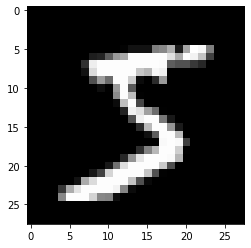

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0], cmap="gray")
im,label = iter(trainloader).next()

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

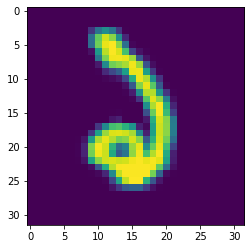

In [10]:
imshow(im[0])

In [11]:
im[0].shape

torch.Size([1, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


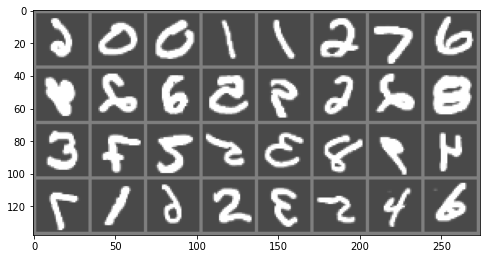

In [12]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4. Define the network (AlexNet)

![AlexNet](https://img-blog.csdnimg.cn/94df3c1ed5914654a5ebbf782d1a8ad1.png)

**AlexNet structure:**

    Input layer: The image size is 227×227×3, where 3 means the number of channels (R, G, B) of the input image is 3.
    
    Convolutional layer: filter size 11×11, number of filters 96, convolution stride s=4. (The filter size only lists the width and height, the number of channels of the filter matrix is ​​the same as the number of channels of the input image, which is not listed here)
    
    Pooling layer: max pooling, filter size 3×3, stride s=2.
    
    Convolutional layer: The filter size is 5×5, the number of filters is 256, the stride is s=1, and the padding uses the same convolution, that is, the output image of the convolutional layer and the input image remain unchanged in width and height.
    
    Pooling layer: max pooling, filter size 3×3, stride s=2.
    
    Convolutional layer: filter size 3×3, filter number 384, stride s=1, padding uses the same convolution.
    
    Convolutional layer: filter size 3×3, filter number 384, stride s=1, padding uses the same convolution.
    
    Convolutional layer: filter size 3×3, filter number 256, stride s=1, padding uses the same convolution.
    
    Pooling layer: max pooling, filter size 3×3, step size s=2; after the pooling operation, flatten the output matrix of size 6×6×256 into a 9216-dimensional vector.
    
    Fully connected layer: The number of neurons is 4096.
    
    Fully connected layer: The number of neurons is 4096.
    
    Fully connected layer, output layer: softmax activation function, the number of neurons is 1000, representing 1000 categories.
 

**Some properties of AlexNet:**

    about 60million parameters;
    
    Use ReLU as activation function.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# define the neural network
class AlexNet(nn.Module): # Train ALexNet
    '''
    5 layers of convolution, 3 layers of fully connected
    '''
    def __init__(self):
        super(AlexNet, self).__init__()
        # five convolutional layers input 32 *32* 3
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1), # (32-3+2)/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (32-2)/2+1 = 16
        )
        self.conv2 = nn.Sequential( # input 16 *16* 6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1), # (16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (16-2)/2+1 = 8
        )
        self.conv3 = nn.Sequential( # input 8 *8* 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (8-2)/2+1 = 4
        )
        self.conv4 = nn.Sequential( # input 4 *4* 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (4-3+2)/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (4-2)/2+1 = 2
        )
        self.conv5 = nn.Sequential( # input 2 *2* 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),# (2-3+2)/1+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (2-2)/2+1 = 1
        ) # last convolutional layer, output 1 *1* 128
        # fully connected layer
        self.dense = nn.Sequential(
            nn.Linear(128, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size()[0],-1)
        x = self.dense(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    

net = AlexNet().to(device)

In [15]:
summary(net,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]              60
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             880
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          18,496
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
             ReLU-14            [-1, 12

In [16]:
print(net)

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [17]:
test_x = torch.randn(1,1,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([1, 10])


In [18]:
net = AlexNet().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # When the calculation graph does not change (the input shape is the same each time, the model does not change), the performance can be improved, otherwise the performance will be reduced
    torch.backends.cudnn.benchmark=True


### 5. Define the loss function and optimizer

 Pytorch encapsulates all the optimization methods commonly used in deep learning in torch.optim, and all optimization methods inherit the base class optim.Optimizier

 The loss function is encapsulated in the neural network toolbox nn, which contains many loss functions


In [19]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) 
import time
epoch = 20


### 6. Training


In [20]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The folder already exists')
save_path = './model/AlexNet.pth'

The folder already exists


In [21]:


Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:2.242744  Train Acc:16.38% Test Loss:1.564818  Test Acc:48.96%  Learning Rate:0.010000	Time 00:09
Epoch [  2/ 20]  Train Loss:0.557602  Train Acc:81.34% Test Loss:0.237204  Test Acc:92.49%  Learning Rate:0.010000	Time 00:09
Epoch [  3/ 20]  Train Loss:0.188081  Train Acc:94.09% Test Loss:0.126848  Test Acc:95.90%  Learning Rate:0.010000	Time 00:09
Epoch [  4/ 20]  Train Loss:0.122244  Train Acc:96.16% Test Loss:0.093338  Test Acc:97.04%  Learning Rate:0.010000	Time 00:09
Epoch [  5/ 20]  Train Loss:0.093938  Train Acc:97.06% Test Loss:0.080292  Test Acc:97.36%  Learning Rate:0.010000	Time 00:09
Epoch [  6/ 20]  Train Loss:0.081122  Train Acc:97.44% Test Loss:0.089411  Test Acc:97.25%  Learning Rate:0.010000	Time 00:09
Epoch [  7/ 20]  Train Loss:0.069007  Train Acc:97.81% Test Loss:0.085780  Test Acc:97.17%  Learning Rate:0.010000	Time 00:09
Epoch [  8/ 20]  Train Loss:0.063874  Train Acc:97.98% Test Loss:0.071556  Test Acc:97.75%  Learning Rate:0.010000	Tim

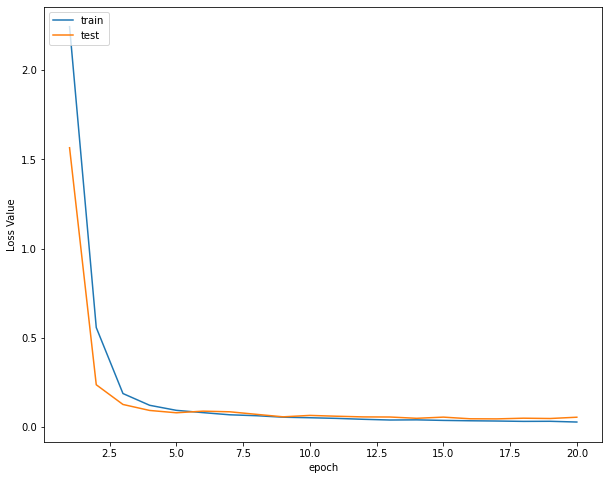

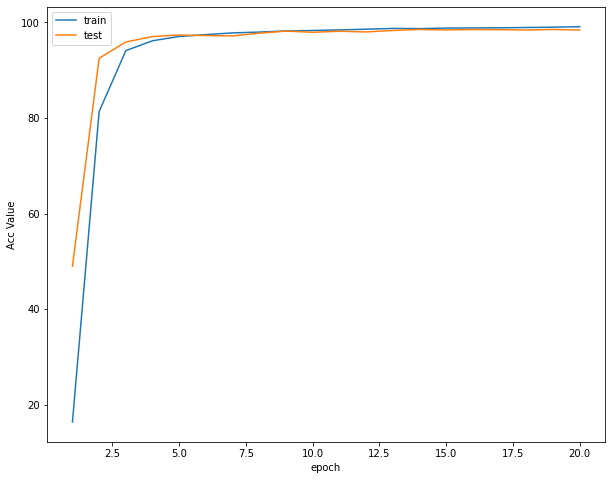

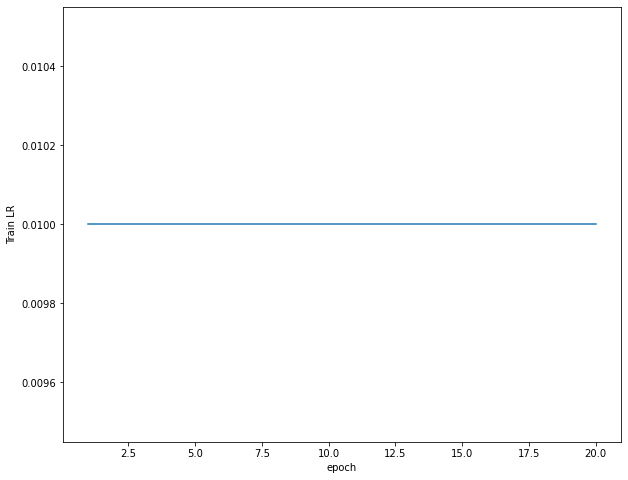

In [22]:
plot_history(epoch ,Acc, Loss, Lr)


### 7. Test


In [23]:
correct = 0 # Define the number of correctly predicted images, initialized to 0 
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)

for data in testloader: # Loop through each batch 
    images, labels = data 
    images = images.to(device) 
    labels = labels.to(device) 
    net.eval() 
    # Convert the model to test mode 
    if hasattr(torch.cuda, 'empty_cache'): 
        torch.cuda.empty_cache() 
    outputs = net(images) # Enter the network for testing
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 98.38 %


`torch.max(outputs.data, 1)` in the program, which returns a tuple (tuple)

And it is obvious here that the first element of this returned tuple is image data, which is the largest value, and the second element is label, which is the index of the largest value! We only need the label (the index of the maximum value), so there will be assignment statements such as ` _`, predicted, which means to ignore the first return value and assign it to `_`, which means to discard it ;

In [24]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 98.47 %
Accuracy of 1 - one : 98.94 %
Accuracy of 2 - two : 98.84 %
Accuracy of 3 - three : 99.21 %
Accuracy of 4 - four : 98.78 %
Accuracy of 5 - five : 96.75 %
Accuracy of 6 - six : 96.87 %
Accuracy of 7 - seven : 97.28 %
Accuracy of 8 - eight : 99.49 %
Accuracy of 9 - nine : 98.81 %


Accuracy Rate = 100.0%


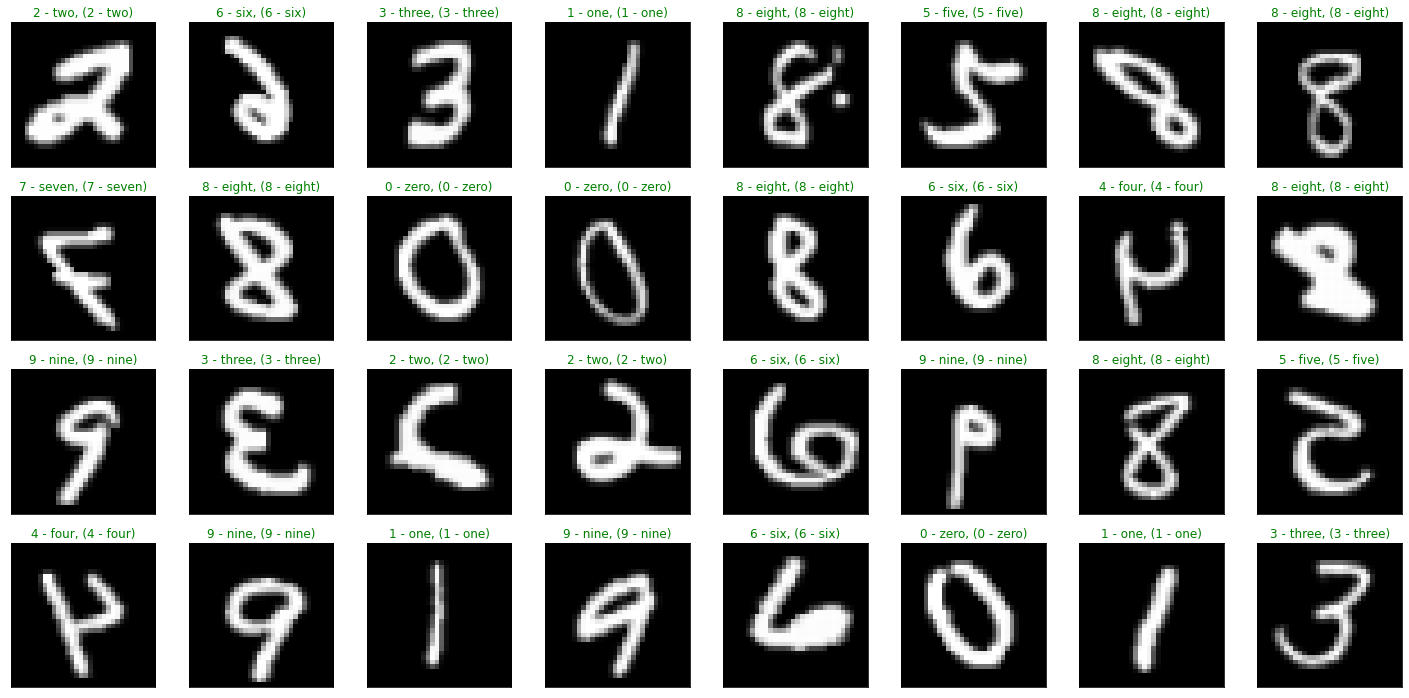

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)


correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

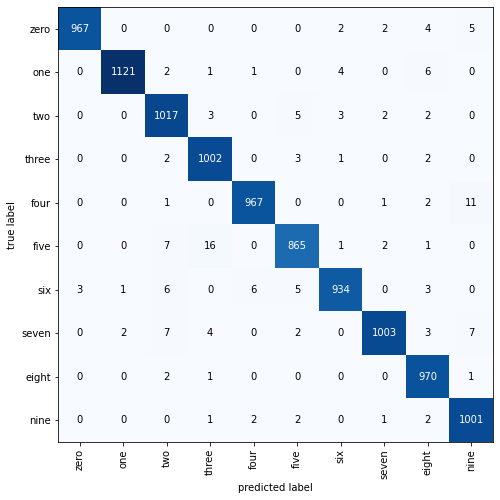

In [26]:
class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cuda'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()


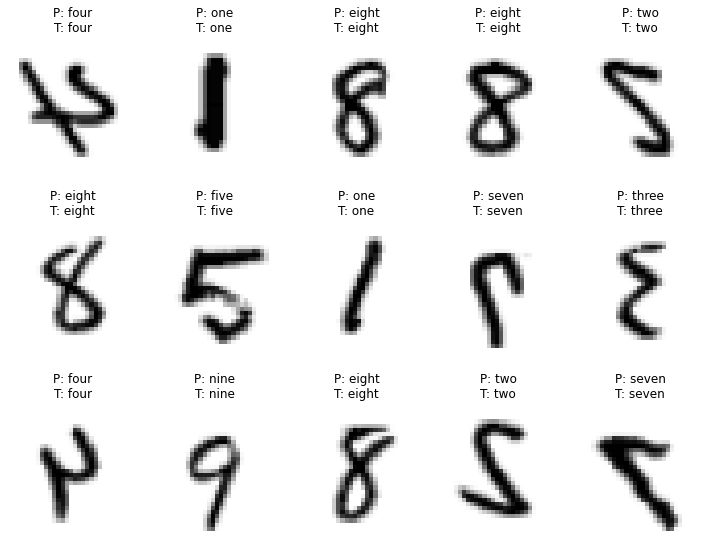

In [27]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net.to('cpu'), data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

In [28]:
Acc

{'train_acc': [16.377376556396484,
  81.33773803710938,
  94.09260559082031,
  96.16204833984375,
  97.05878448486328,
  97.4447021484375,
  97.80672454833984,
  97.97774505615234,
  98.20651245117188,
  98.30923461914062,
  98.43029022216797,
  98.57521057128906,
  98.7362289428711,
  98.70069885253906,
  98.81175231933594,
  98.84228515625,
  98.87060546875,
  98.92890930175781,
  99.00275421142578,
  99.10326385498047],
 'test_acc': [48.961631774902344,
  92.49407196044922,
  95.89596557617188,
  97.04312133789062,
  97.35957336425781,
  97.25079345703125,
  97.17167663574219,
  97.74525451660156,
  98.18038177490234,
  97.93315124511719,
  98.15071105957031,
  98.00237274169922,
  98.30894470214844,
  98.52650451660156,
  98.417724609375,
  98.51661682128906,
  98.47705841064453,
  98.4078369140625,
  98.52650451660156,
  98.39794921875]}

In [29]:
Loss

{'train_loss': [2.242743968963623,
  0.5576015114784241,
  0.18808095157146454,
  0.12224382907152176,
  0.09393756836652756,
  0.08112185448408127,
  0.0690065249800682,
  0.06387369334697723,
  0.05550570785999298,
  0.05257029086351395,
  0.048936374485492706,
  0.043807677924633026,
  0.03978067263960838,
  0.04068651422858238,
  0.037572283297777176,
  0.03554574400186539,
  0.034120410680770874,
  0.03212592005729675,
  0.03261436149477959,
  0.028468051925301552],
 'test_loss': [1.564818263053894,
  0.2372044175863266,
  0.12684784829616547,
  0.09333763271570206,
  0.08029210567474365,
  0.08941144496202469,
  0.08578041195869446,
  0.07155576348304749,
  0.0576181560754776,
  0.06556224077939987,
  0.06098948419094086,
  0.057156022638082504,
  0.05656399577856064,
  0.04936819151043892,
  0.05594748631119728,
  0.04669560119509697,
  0.04608704894781113,
  0.04991687089204788,
  0.0482085682451725,
  0.05546104162931442]}


### 8. Save the model


In [30]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')